# Similarity Measures for Fish Welfare Criteria
### Initial Hypotheses
Certain pairs of criteria will have a higher potential of being jointly met, be that because farms that meet this criteria, generally also meet the other criteria, or because criteria are inter-related somehow. For example, we might imagine stress and aggression to be positively correlated as we expect stress to exacerbate aggression, and we might expect home range and aggression to be correlated as fish in confined spaces may become more aggressive.

* [_An ordinal attribute is an attribute whose possible values have a meaningful order or ranking among them, but the magnitude between successive values is not known._](https://www.raynergobran.com/2016/02/distance-observations-numeric-ordinal/)
* [Distance for ordinal measures](https://people.revoledu.com/kardi/tutorial/Similarity/OrdinalVariables.html)
* [Previous work from bootcamp](https://www.overleaf.com/project/60d210fc6e835b84704f2b57)

### Criteria (explanations to be added later)
| Id | Criterion      | Description |
| --- | ----------- | ----------- |
| 17 | Home range      |        |
| 18 | Depth range   |         |
| 29 | Migration   |         |
| 30 | Reproduction   |         |
| 31 | Aggregation   |         |
| 32 | Aggression   |         |
| 33 | Substrate   |         |
| 34 | Stress   |         |
| 35 | Malformation   |         |
| 36 | Slaughter   |         |

### Data description
10 different criteria, 55 fish ids. Likelihood is binary and Potential has three categories.


### Questions
* What similarity measure is suitable for sparse, ordinal data, with additional certainty scores?

#### Measures to try
* Euclidean distance
* nan-Euclidean distance
* Hamming distance
* nan-Hamming distance
* Cosine similarity: not meaningful for sparse data
* Resampling

In [1]:
from os.path import exists, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import nan_euclidean_distances

from taxonomic_categories import classes_species

def make_multilevel(likelihood, potential):
    """Combine Likelihood and Potential into a multilevel dataframe."""
    likelihood_t = likelihood.transpose()
    likelihood_t['level'] = ['likelihood'] * 10

    potential_t = potential.transpose()
    potential_t['level'] = ['potential'] * 10
    
    both = pd.concat([likelihood_t, potential_t])
    both = both.groupby(['Criterion', 'level']).agg(lambda x: x)
    both = both.transpose()
    
    return both

def make_heatmap(df, row1, row2, possible_values, **kwargs):
    """Make a heatmap for value counts of each ranking. 
    
    Clearer than scatter plots for ordinal data.
    Colours indicate frequency a value is recorded."""
    
    n = len(possible_values)
    pv_dict = {index: value for index, value in zip(range(n), possible_values)}
    pv_dict_r = {value: key for key, value in pv_dict.items()}
    
    value_counts = np.zeros((n, n))
    
    for ix, row in df[[row1, row2]].iterrows():
        if (not np.isnan(row[row1])) and (not np.isnan(row[row2])):
            
            idx1 = pv_dict_r[int(row[row1])]
            idx2 = pv_dict_r[int(row[row2])]
            value_counts[idx1, idx2] += 1
        
    return value_counts, pv_dict

def plot_heatmap(measure, col1, col2, values, ax, title, lims=[0, 20], cbar=True):
    heatmap, pv_dict = make_heatmap(measure, criteria_dict_r[col1], criteria_dict_r[col2], values)
    im = ax.imshow(heatmap, vmin=lims[0], vmax=lims[1])
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.set_xticks([*pv_dict.keys()])
    ax.set_yticks([*pv_dict.keys()])
    ax.set_xticklabels([*pv_dict.values()])
    ax.set_yticklabels([*pv_dict.values()])
    ax.invert_yaxis()
    ax.set_title(f'Heatmap of value-pairs\nfor {title}')
    if cbar:
        plt.colorbar(im);
    return im

wd = join('..', '..', 'data')

[('Acipenser', 6), ('Oncorhynchus', 4), ('Salmo', 3)]
Cephalopoda:, 3
Actinopterygii:, 65
Malacostraca:, 7


## Load and initial look at data

In [32]:
subsetting = True
df = pd.read_csv(join(wd, 'feb_farm_data_s2.csv'))

if subsetting:
    actinopterygii = classes_species['Actinopterygii']
    df_temp = df[['Fish', 'Name']].dropna()
    fish_ids = {int(key): value for key, value in zip(df_temp['Fish'], df_temp['Name'])}
    fish_ids_r = {value: key for key, value in fish_ids.items()}
    actinopterygii_ids = [fish_ids_r[fish] for fish in actinopterygii]
    df = df[df['Fish ID'].isin(actinopterygii_ids)]

# get criterion dictionary
criteria_df = df.head(10)[['Criterion.1', 'Unnamed: 7']].set_index('Criterion.1')
criteria_df.index.name = 'index'
criteria_df.columns = ['criterion']
criteria_dict = {int(val): name for val, name in zip(criteria_df.index, criteria_df['criterion'])}
criteria_dict_r = {value: key for key, value in criteria_dict.items()}

# set up dataframe for each of likelihood, potential, and uncertainty
likelihood = df.pivot(index="Fish ID", columns="Criterion", values="Likelihood")
potential = df.pivot(index="Fish ID", columns="Criterion", values="Potential")
certainty = df.pivot(index="Fish ID", columns="Criterion", values="Certainty")

# combine into one multiindex df (useful for operations later)
df_all = make_multilevel(likelihood, potential)

In [33]:
# Check unique values (<0 should be removed)
print(set(likelihood.values.ravel()))
print(set(potential.values.ravel()))

{0, 2, -1, -2}
{0, 1, 2, -2, -1}


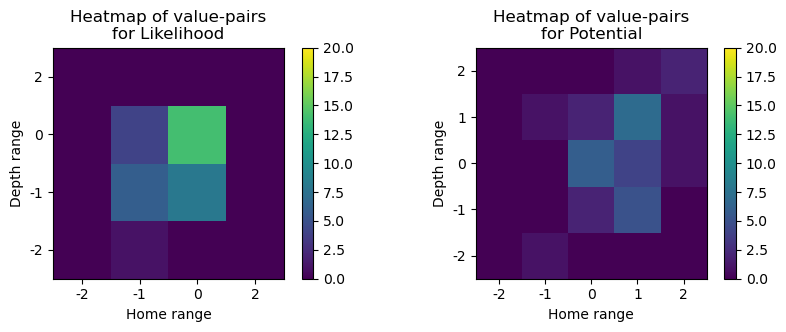

In [34]:
# inspect a single pair of criteria for Potential and Likelihood
i = 'Home range'
j = 'Depth range'

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

plot_heatmap(likelihood, i, j, [-2, -1, 0, 2], axs[0], 'Likelihood')
plot_heatmap(potential, i, j, [-2, -1, 0, 1, 2], axs[1], 'Potential')

In [35]:
# make a multilevel dataframe and remove negative values
idx = pd.IndexSlice
both = make_multilevel(likelihood, potential)
both = both.applymap(lambda x: np.nan if x < 0 else x)
likelihood = both.loc[:, idx[:, 'likelihood']].droplevel('level', axis=1)
potential = both.loc[:, idx[:, 'potential']].droplevel('level', axis=1)

# get normalised rank transformations (to use with quantitative distance measures such as Euclidean)
likelihood_z = (likelihood / 2) / (2 - 1)
potential_z = (potential) / (3 - 1)

In [36]:
# look at data now, all negatives are replaces by NaNs
likelihood.head()

Criterion,17,18,29,30,31,32,33,34,35,36
Fish ID,,,,,,,,,,
1,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,2.0
10,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
16,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0
17,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,2.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# look at what unique values exist in dataframe
print(set(pd.unique(likelihood.values.ravel('K'))))
print(set(pd.unique(potential.values.ravel('K'))))

{0.0, 2.0, nan}
{0.0, 1.0, 2.0, nan}


In [38]:
# look at what unique values exist in dataframe
print(set(pd.unique(likelihood_z.values.ravel('K'))))
print(set(pd.unique(potential_z.values.ravel('K'))))

{0.0, 1.0, nan}
{0.5, 1.0, nan, 0.0}


# Measures in one dimension
## Euclidean Distance

$$ d(\mathbf{u}, \mathbf{v}) = \sqrt{\sum_{i=1}^n \left(u_i - v_i \right)^2} $$

## nan-Euclidean Distance
$$ d(\mathbf{u}, \mathbf{v}) = \sqrt{\frac{T}{P} \sum_{i=1}^n \left(u_i - v_i \right)^2} $$

In [39]:
i = 'Home range'
j = 'Depth range'
col1 = criteria_dict_r[i]
col2 = criteria_dict_r[j]

m = "Substrate"
n = "Slaughter"
col3 = criteria_dict_r[m]
col4 = criteria_dict_r[n]

In [40]:
# look at example results
def euclidean_dist(df, col1, col2):
    """Requires normalised data."""
    return np.sqrt(((df[col1] - df[col2]) ** 2).sum(skipna=True))

def nan_euclidean_dist(df, col1, col2):
    """Requires normalised data."""
    T = len(df)
    P = T - len(df[[col1, col2]].dropna())
    
    return np.sqrt((T / P) * ((df[col1] - df[col2]) ** 2).sum(skipna=True))

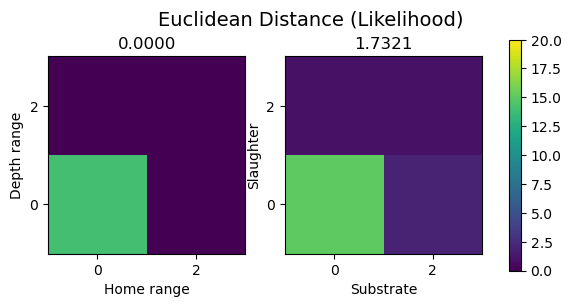

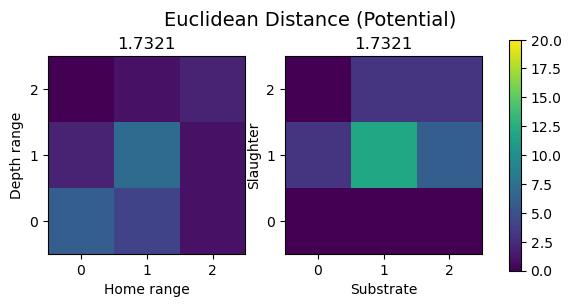

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(likelihood, i, j, [0, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(likelihood, m, n, [0, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{euclidean_dist(likelihood_z, col1, col2):.4f}");
axs[1].set_title(f"{euclidean_dist(likelihood_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Euclidean Distance (Likelihood)", fontsize=14);


fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(potential, i, j, [0, 1, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(potential, m, n, [0, 1, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{euclidean_dist(potential_z, col1, col2):.4f}");
axs[1].set_title(f"{euclidean_dist(potential_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Euclidean Distance (Potential)", fontsize=14);

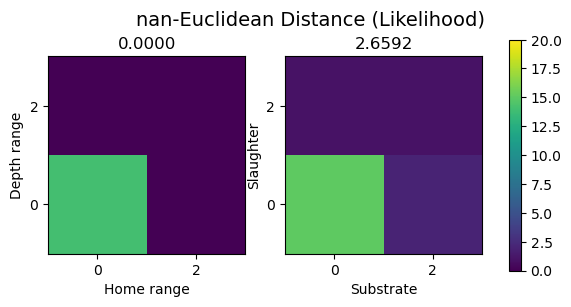

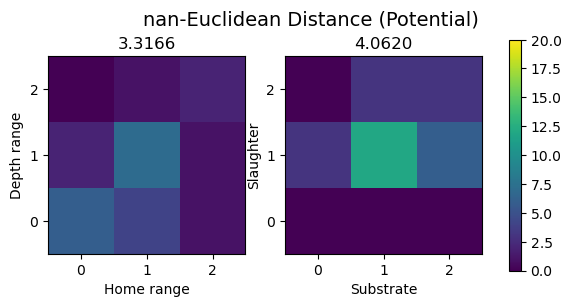

In [42]:
# look at example results
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(likelihood, i, j, [0, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(likelihood, m, n, [0, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{nan_euclidean_dist(likelihood_z, col1, col2):.4f}");
axs[1].set_title(f"{nan_euclidean_dist(likelihood_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("nan-Euclidean Distance (Likelihood)", fontsize=14);


fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(potential, i, j, [0, 1, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(potential, m, n, [0, 1, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{nan_euclidean_dist(potential_z, col1, col2):.4f}");
axs[1].set_title(f"{nan_euclidean_dist(potential_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("nan-Euclidean Distance (Potential)", fontsize=14);

## Hamming distance

$$ d(\mathbf{u}, \mathbf{v}) = \sqrt{\sum_{i=1}^n |u_i - v_i |} $$


## nan-Hamming distance

$$ d(\mathbf{u}, \mathbf{v}) = \sqrt{ \frac{T}{P} \sum_{i=1}^n |u_i - v_i |} $$

In [43]:
# look at example results
def hamming_dist(df, col1, col2):
    """Requires normalised data."""
    return np.sqrt(np.abs(df[col1] - df[col2]).sum(skipna=True))

def nanhamming_dist(df, col1, col2):
    """Requires normalised data."""
    T = len(df)
    P = T - len(df[[col1, col2]].dropna())
    
    return np.sqrt((T / P) * np.abs(df[col1] - df[col2]).sum(skipna=True))

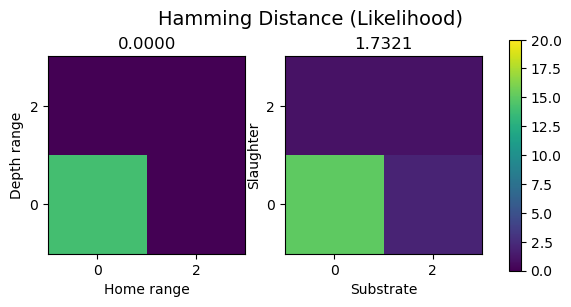

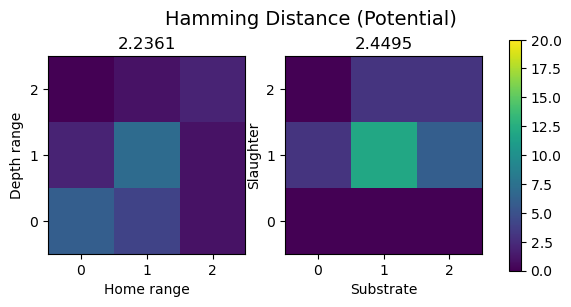

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(likelihood, i, j, [0, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(likelihood, m, n, [0, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{hamming_dist(likelihood_z, col1, col2):.4f}");
axs[1].set_title(f"{hamming_dist(likelihood_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Hamming Distance (Likelihood)", fontsize=14);


fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(potential, i, j, [0, 1, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(potential, m, n, [0, 1, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{hamming_dist(potential_z, col1, col2):.4f}");
axs[1].set_title(f"{hamming_dist(potential_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Hamming Distance (Potential)", fontsize=14);

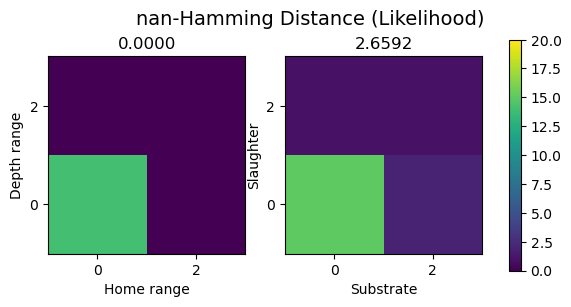

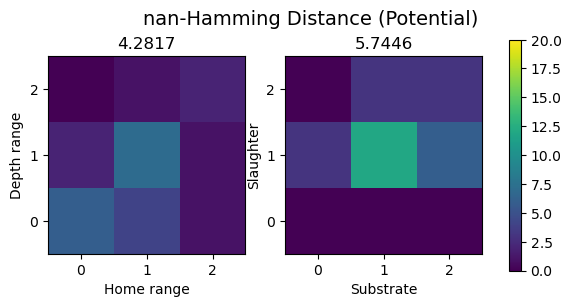

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(likelihood, i, j, [0, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(likelihood, m, n, [0, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{nanhamming_dist(likelihood_z, col1, col2):.4f}");
axs[1].set_title(f"{nanhamming_dist(likelihood_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("nan-Hamming Distance (Likelihood)", fontsize=14);


fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(potential, i, j, [0, 1, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(potential, m, n, [0, 1, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{nanhamming_dist(potential_z, col1, col2):.4f}");
axs[1].set_title(f"{nanhamming_dist(potential_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("nan-Hamming Distance (Potential)", fontsize=14);

## Cosine Similarity

$$ S_c(\mathbf{u}, \mathbf{v}) = \cos(\theta) = \frac{\mathbf{u} \cdot \mathbf{v}}{||\mathbf{u}||\cdot||\mathbf{v}||} = \frac{\sum_i^n u_iv_i}{\sqrt{\sum_i^n u_i^2}\sqrt{\sum_i^n v_i^2}} $$

Can't calculate cosine similarity for zero vector. Returning NaN.



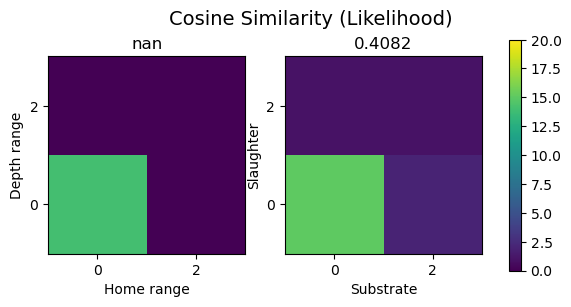

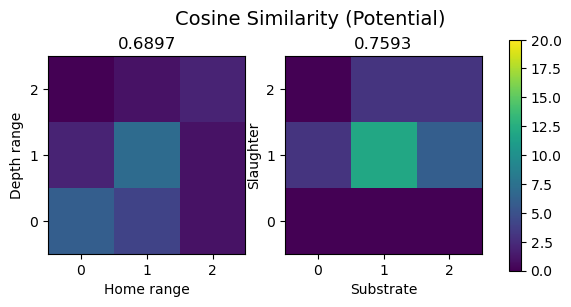

In [46]:
def cosine_similarity(df, col1, col2):
    """Requires normalised data"""
    if (df[col1].sum() == 0) or (df[col2].sum() == 0):
        print("Can't calculate cosine similarity for zero vector. Returning NaN.\n")
        return np.nan
    return (df[col1] * df[col2]).sum() / ( np.sqrt((df[col1] ** 2).sum()) * np.sqrt((df[col2] ** 2).sum()))


# look at example results
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(likelihood, i, j, [0, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(likelihood, m, n, [0, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{cosine_similarity(likelihood, col1, col2):.4f}");
axs[1].set_title(f"{cosine_similarity(likelihood, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Cosine Similarity (Likelihood)", fontsize=14);


fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(potential, i, j, [0, 1, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(potential, m, n, [0, 1, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{cosine_similarity(potential, col1, col2):.4f}");
axs[1].set_title(f"{cosine_similarity(potential, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Cosine Similarity (Potential)", fontsize=14);

## Plots

In [47]:
global N, thresh
N = 55
thresh = 15  # if less than 10 values present the return nan

def cosine_similarity(col1, col2):
    P = len(col1)
    if P < thresh:
        return np.nan
    
    if (col1.sum() == 0) or (col2.sum() == 0):
        return np.nan
    
    return (col1 * col2).sum() / ( np.sqrt((col1 ** 2).sum()) * np.sqrt((col2 ** 2).sum()))

def euclidean_similarity(col1, col2):
    """Requires normalised data. Not bounded. Return NaN if less than 1/3 data present."""
    # count number present/missing
    P = len(col1)
    if P < thresh:
        return np.nan
    euclidean_dist = np.sqrt(((col1 - col2) ** 2).sum())
    return 1 / (1 + euclidean_dist)

def naneuclidean_similarity(col1, col2):
    """Requires normalised data. Not bounded."""
    # count number present/missing
    P = len(col1)
    if P < thresh:
        return np.nan
    
    # get metric
    euclidean_dist = np.sqrt((N / P) * ((col1 - col2) ** 2).sum())
    return 1 / (1 + euclidean_dist)

def hamming_similarity(col1, col2):
    """Requires normalised data?"""
    P = len(col1)
    if P < thresh:
        return np.nan
    hamming_dist = np.sqrt(np.abs(col1 - col2).sum())
    return 1 / (1 + hamming_dist)

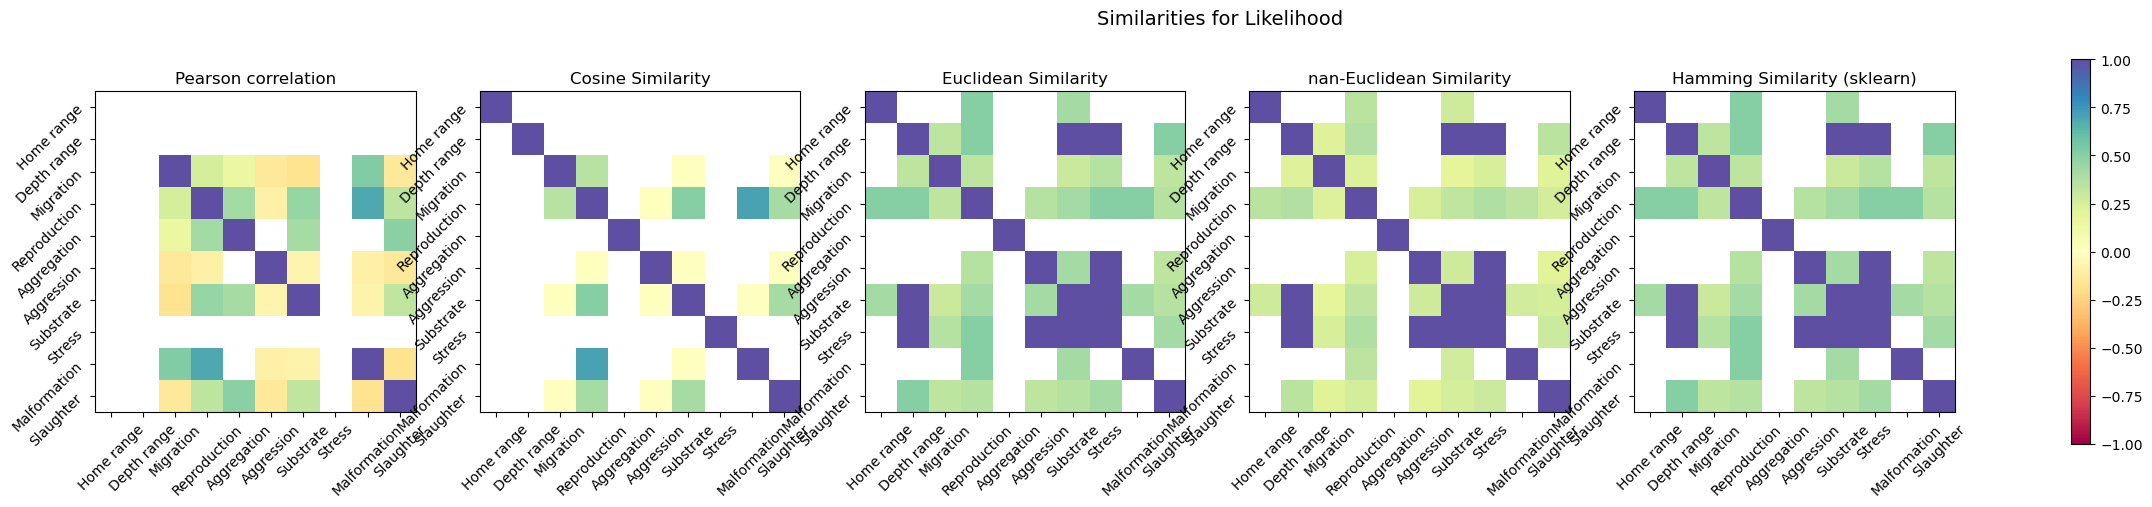

In [48]:
# plot correlation coefficients
pearson_likelihood = likelihood.corr(method='pearson')
cosine_likelihood = likelihood.corr(method=cosine_similarity)
euclidean_likelihood = likelihood_z.corr(method=euclidean_similarity)
# naneuclidean_likelihood = 1 / (1 + nan_euclidean_distances(likelihood.transpose(), likelihood.transpose()))
naneuclidean_likelihood = likelihood_z.corr(method=naneuclidean_similarity)
hamming_likelihood = likelihood_z.corr(method=hamming_similarity)

fig, axs = plt.subplots(1, 5, figsize=(30, 5))

ax = axs[0]
im = ax.imshow(pearson_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Pearson correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
# plt.colorbar(im, ax=ax);


ax = axs[1]
im = ax.imshow(cosine_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
# plt.colorbar(im, ax=ax);

ax = axs[2]
im = ax.imshow(euclidean_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
# plt.colorbar(im, ax=ax);

ax = axs[3]
im = ax.imshow(naneuclidean_likelihood, cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('nan-Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
# plt.colorbar(im, ax=ax);

ax = axs[4]
im = ax.imshow(hamming_likelihood, cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Hamming Similarity (sklearn)')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
# plt.colorbar(im, ax=ax);

fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Similarities for Likelihood", fontsize=14);

fig.savefig(join('..', 'images', 'likelihood.png'))

Pairs of criteria where less than 15 (thresh) value-pairs are present are not considered and returned as NaN. For Pearson and Cosine similarity, if either vector is the zero vector then the measure is undefined and this is also returned as NaN. Euclidean and Hamming similarity are similar, as expected. Nan-Euclidean similarity slighty reduces the similarity predicted where there are less samples present, which is good we don't want to give equal weight when a lot of data is missing. However, in the case where both sets are all zero, unsure if it is accurate to give this a correlation of one.


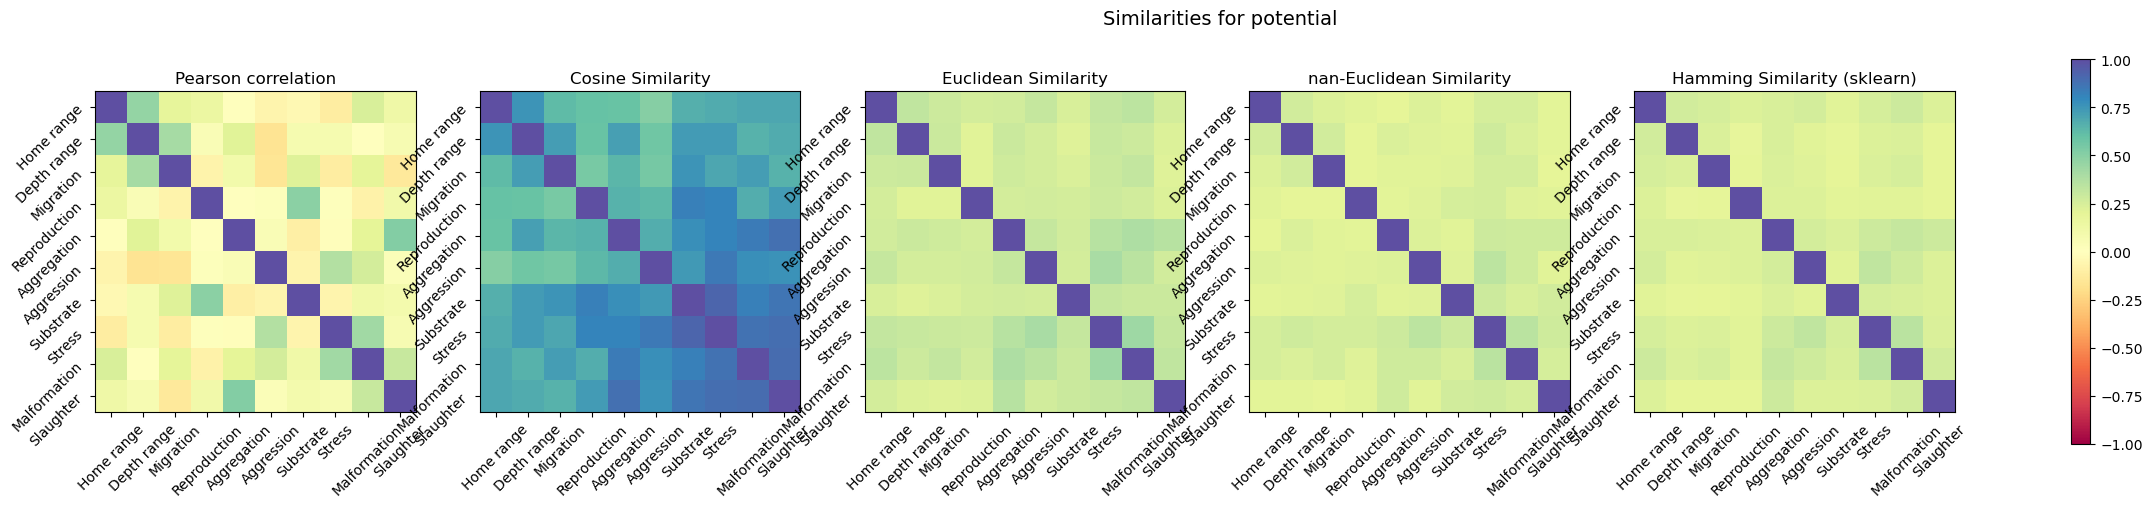

In [20]:
# plot correlation coefficients
pearson_potential = potential.corr(method='pearson')
cosine_potential = potential.corr(method=cosine_similarity)
euclidean_potential = potential_z.corr(method=euclidean_similarity)
# naneuclidean_potential = 1 / (1 + nan_euclidean_distances(potential.transpose(), potential.transpose()))
naneuclidean_potential = potential_z.corr(method=naneuclidean_similarity)
hamming_potential = potential_z.corr(method=hamming_similarity)

fig, axs = plt.subplots(1, 5, figsize=(30, 5))

ax = axs[0]
im = ax.imshow(pearson_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Pearson correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
# plt.colorbar(im, ax=ax);


ax = axs[1]
im = ax.imshow(cosine_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
# plt.colorbar(im, ax=ax);

ax = axs[2]
im = ax.imshow(euclidean_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
# plt.colorbar(im, ax=ax);

ax = axs[3]
im = ax.imshow(naneuclidean_potential, cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('nan-Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
# plt.colorbar(im, ax=ax);

ax = axs[4]
im = ax.imshow(hamming_potential, cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Hamming Similarity (sklearn)')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
# plt.colorbar(im, ax=ax);

fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Similarities for potential", fontsize=14);

fig.savefig(join('..', 'images', 'potential.png'))

# Sampling data 
**Certainty values:** -2 (no findings), 0 (low), 1 (medium), 2 (high). <br>
**Idea:** Re-sample data according to certainty values.
$$ \mathbb{P}_{\text{high}}(a, b, c | a) = (0.99, 0.05, 0.05) $$
$$ \mathbb{P}_{\text{medium}}(a, b, c | a) = (0.90, 0.5, 0.5) $$
$$ \mathbb{P}_{\text{low}}(a, b, c | a) = (0.5, 0.25, 0.25) $$

In [32]:
certainty_probs = {0: (0.005, 0.99), 
                   1: (0.05, 0.9),
                   2: (0.25, 0.5)}

def probabilities(score, possible_scores, certainty):
    high = certainty_probs[certainty][1]
    low = certainty_probs[certainty][0]
    probabilities = [high if pscore==score else low for pscore in possible_scores]
    return probabilities

def random_sample(measure, certainty):
    pass

potential_sample = {}
likelihood_sample = {}

In [98]:
n = 5

for criterion in [*criteria_dict.keys()]:
    sample = np.array([])
    possible_scores = [0, 1, 2]  # potential
    scores = [(score, cert) for score, cert in zip(potential[criterion], certainty[criterion])]
    for score in scores:
        if not np.isnan(score[0]):
            probabilities(score[0], [0, 1, 2], score[1])
            sample = np.append(sample, np.random.choice(possible_scores, n, p=probabilities(score[0], [0, 1, 2], score[1])))
        else:
            sample = np.append(sample, [np.nan] * n)

    potential_sample[criterion] = sample

potential_sample_df = pd.DataFrame.from_dict(potential_sample)
potential_sample_df_z = (potential_sample_df) / (3 - 1)


for criterion in [*criteria_dict.keys()]:
    sample = np.array([])
    possible_scores = [0, 1, 2]  # potential
    scores = [(score, cert) for score, cert in zip(likelihood[criterion], certainty[criterion])]
    for score in scores:
        if not np.isnan(score[0]):
            probabilities(score[0], [0, 1, 2], score[1])
            sample = np.append(sample, np.random.choice(possible_scores, n, p=probabilities(score[0], [0, 1, 2], score[1])))
        else:
            sample = np.append(sample, [np.nan] * n)

    likelihood_sample[criterion] = sample
    
likelihood_sample_df = pd.DataFrame.from_dict(likelihood_sample)
likelihood_sample_df_z = (likelihood_sample_df) / (2 - 1)

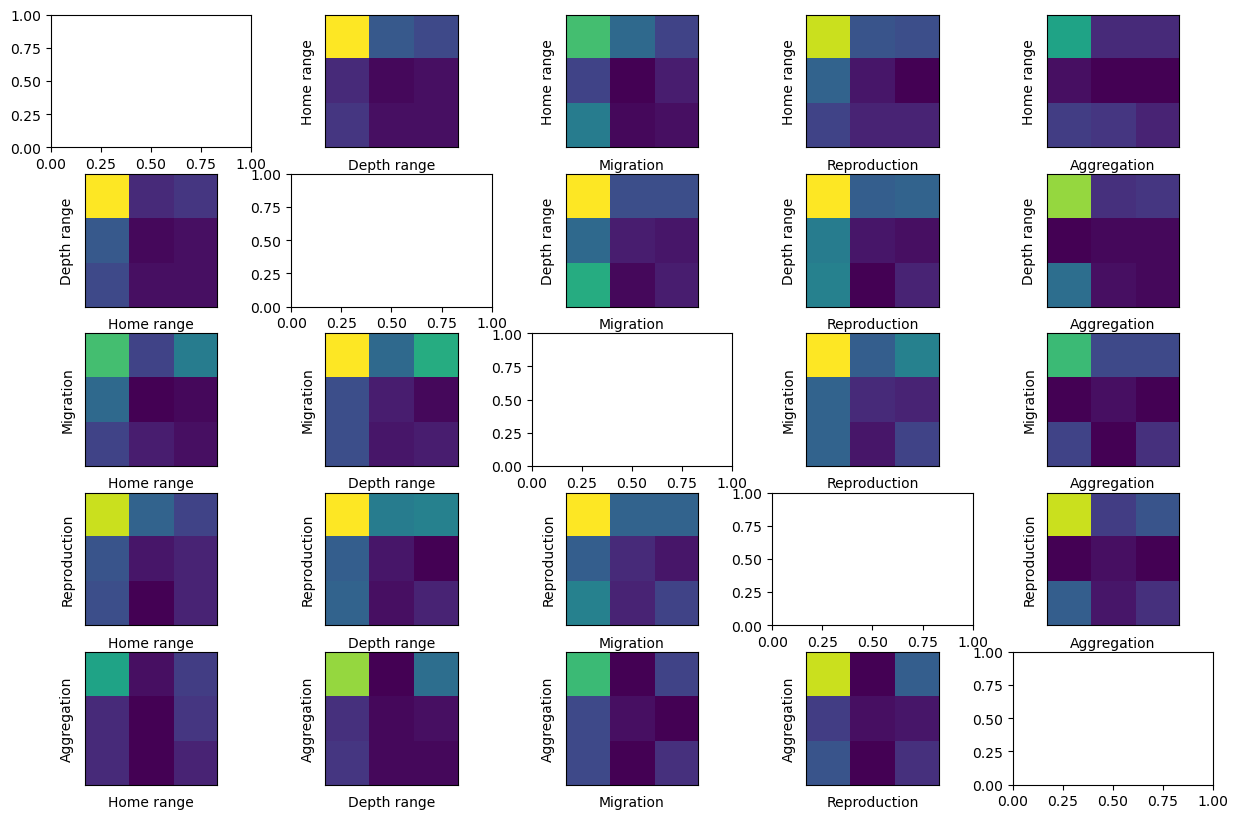

In [253]:
fig, axs = plt.subplots(5, 5, figsize=(15, 10))

for i in range(5):
    for j in range(5):
        if j != i:
            ax = axs[j, i]
            ix = [*criteria_dict.keys()][i]
            jx = [*criteria_dict.keys()][j]
            #print(f"{(ix, jx)}:")

            xlabel = [*criteria_dict.values()][i]
            ylabel = [*criteria_dict.values()][j]

            value_counts = make_heatmap(likelihood_sample_df, ix, jx)
            #print(f"min: {value_counts.min()}, max: {value_counts.max()}")
            ax.imshow(value_counts, vmin=0, vmax=50)

            # make_heatmap(likelihood_sample_df, ix, jx, ax=ax, vmin=2000, vmax=2500)
            #ax.scatter(likelihood_sample_df[ix], likelihood_sample_df[jx], alpha=0.03, s=100)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])

            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
        

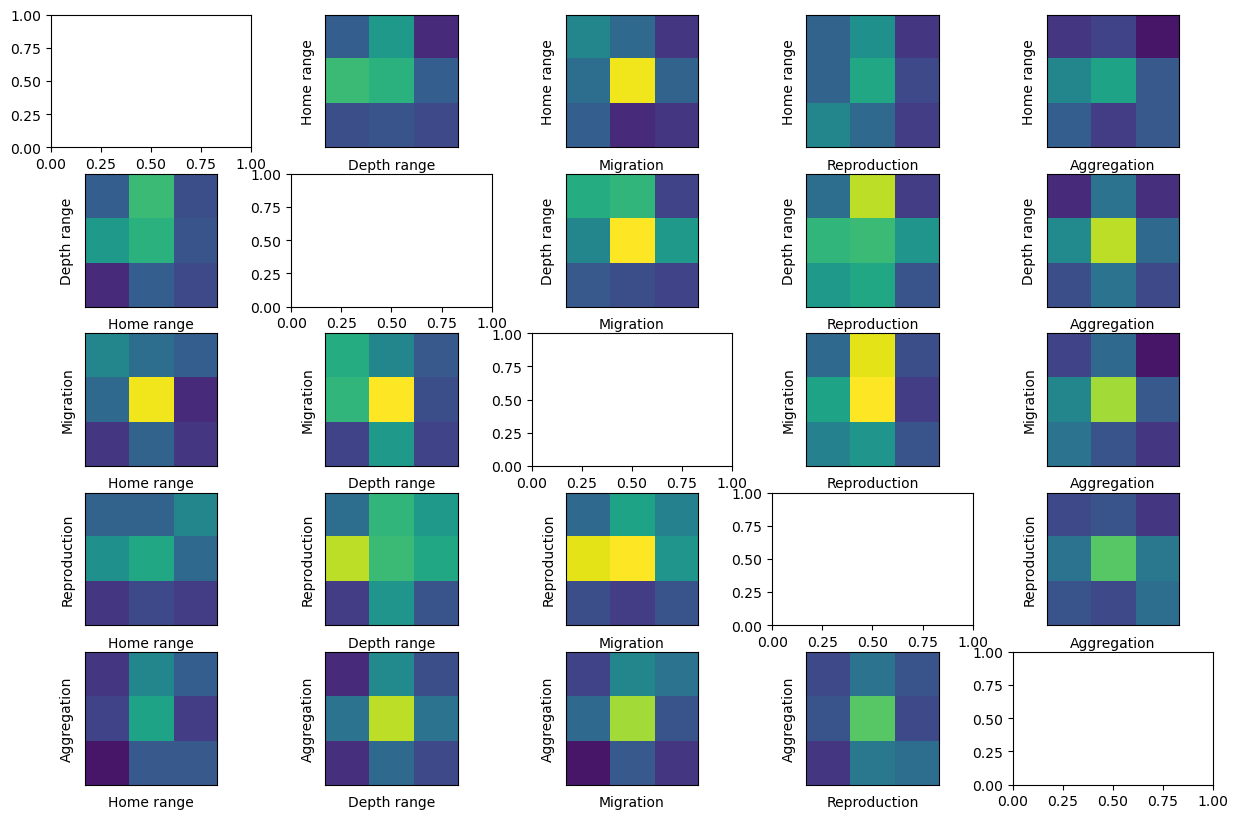

In [258]:
fig, axs = plt.subplots(5, 5, figsize=(15, 10))

for i in range(5):
    for j in range(5):
        if j != i:
            ax = axs[j, i]
            ix = [*criteria_dict.keys()][i]
            jx = [*criteria_dict.keys()][j]
            #print(f"{(ix, jx)}:")

            xlabel = [*criteria_dict.values()][i]
            ylabel = [*criteria_dict.values()][j]

            value_counts = make_heatmap(potential_sample_df, ix, jx)
            #print(f"min: {value_counts.min()}, max: {value_counts.max()}")
            ax.imshow(value_counts, vmin=0, vmax=50)

            #ax.scatter(potential_sample_df[ix], potential_sample_df[jx], alpha=0.03, s=100)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])

            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)

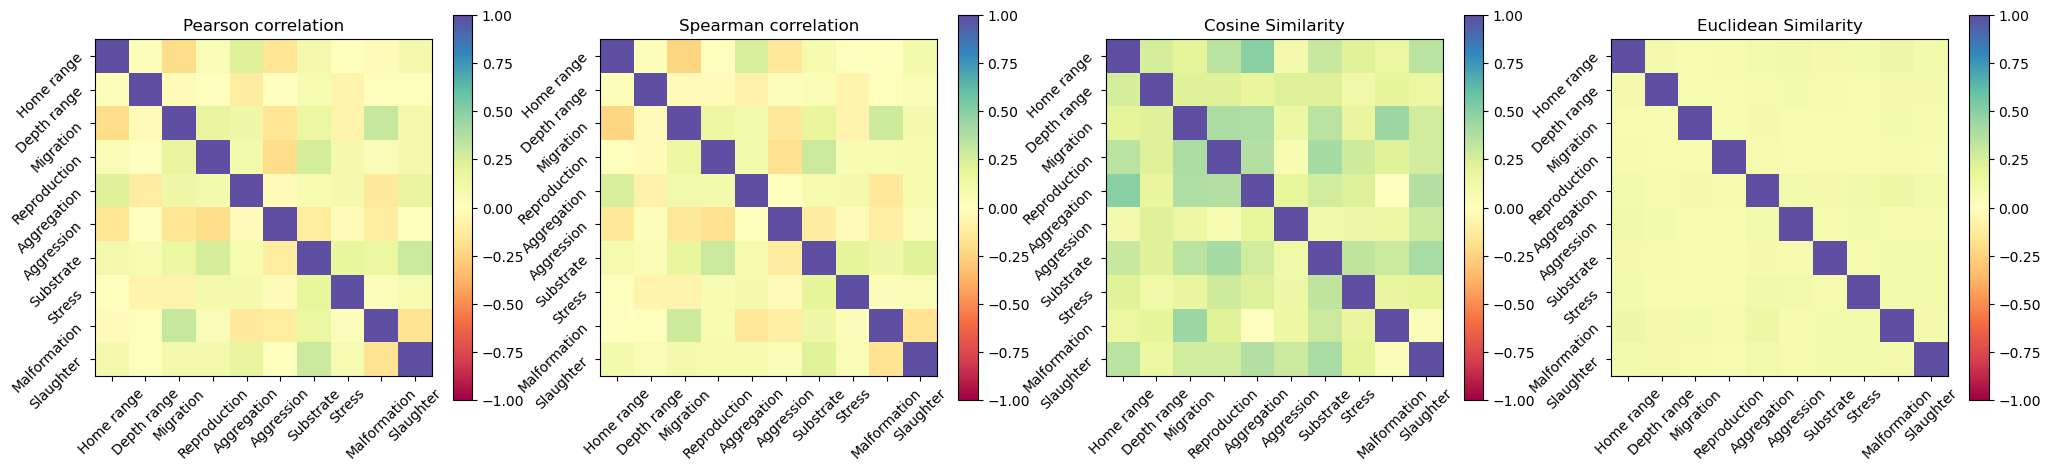

In [100]:
# plot correlation coefficients for likelihood
pearson_likelihood = likelihood_sample_df.corr(method='pearson')
spearman_likelihood = likelihood_sample_df.corr(method='spearman')
cosine_likelihood = likelihood_sample_df.corr(method=cosine_similarity)
euclidean_likelihood = likelihood_sample_df_z.corr(method=euclidean_similarity)

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

ax = axs[0]
im = ax.imshow(pearson_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Pearson correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[1]
im = ax.imshow(spearman_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Spearman correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[2]
im = ax.imshow(cosine_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[3]
im = ax.imshow(euclidean_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);


fig.savefig(join('..', 'images', 'likelihood_resample.png'))

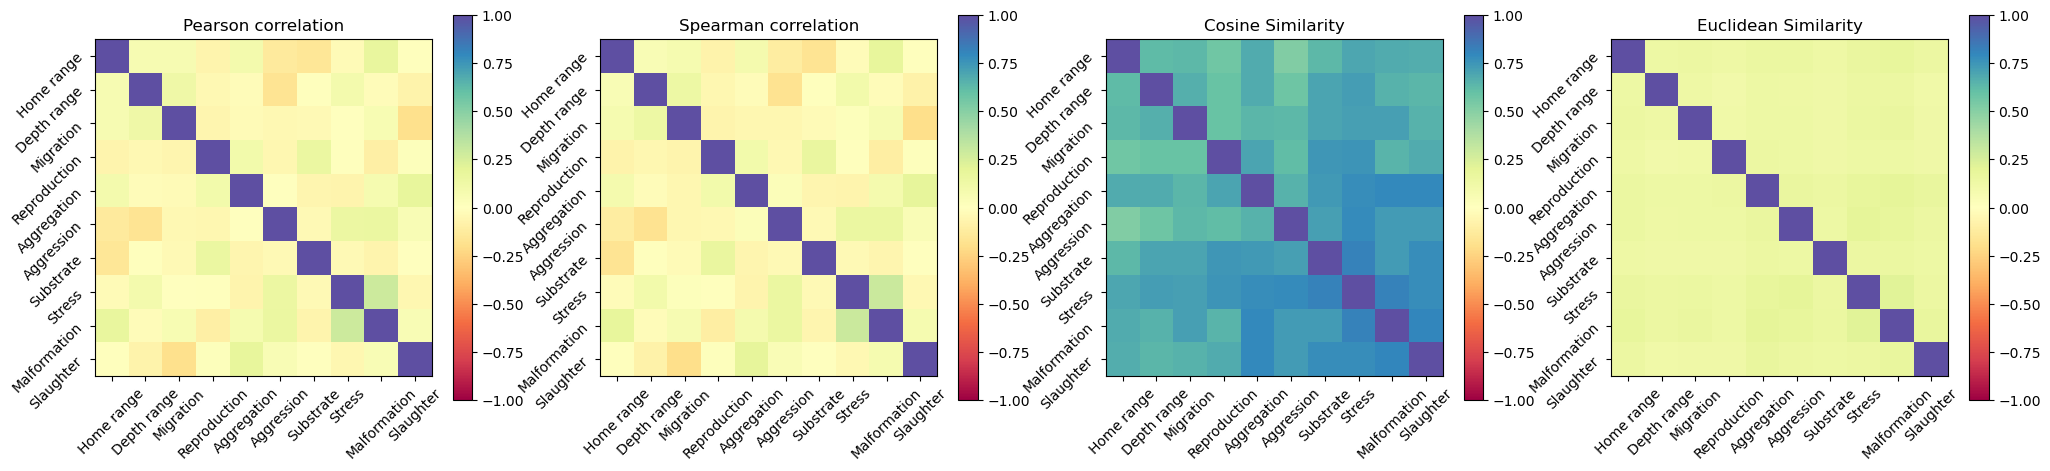

In [101]:
# plot correlation coefficients for potential
pearson_potential = potential_sample_df.corr(method='pearson')
spearman_potential = potential_sample_df.corr(method='spearman')
cosine_potential = potential_sample_df.corr(method=cosine_similarity)
euclidean_potential = potential_sample_df_z.corr(method=euclidean_similarity)

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

ax = axs[0]
im = ax.imshow(pearson_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Pearson correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[1]
im = ax.imshow(spearman_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Spearman correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[2]
im = ax.imshow(cosine_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[3]
im = ax.imshow(euclidean_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

fig.savefig(join('..', 'images', 'potential_resample.png'))

(array([ 8., 20., 18., 22.,  8., 14.,  0.,  0.,  0., 10.]),
 array([0.5621985 , 0.60597865, 0.6497588 , 0.69353895, 0.7373191 ,
        0.78109925, 0.8248794 , 0.86865955, 0.9124397 , 0.95621985,
        1.        ]),
 <BarContainer object of 10 artists>)

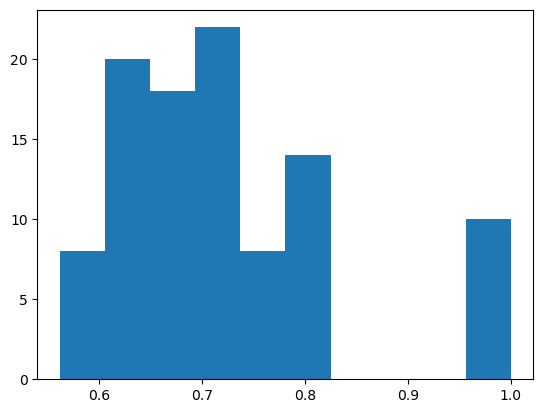

In [73]:
plt.hist(cosine_potential.to_numpy().ravel())

In [60]:
euclidean_potential

,17,18,29,30,31,32,33,34,35,36
17,1.000000,0.035211,0.033162,0.034325,0.038111,0.041933,0.032961,0.042294,0.044899,0.035133
18,0.035211,1.000000,0.030661,0.026891,0.036038,0.034850,0.028267,0.035762,0.036135,0.028833
29,0.033162,0.030661,1.000000,0.027397,0.035893,0.034267,0.030879,0.037398,0.040389,0.030178
30,0.034325,0.026891,0.027397,1.000000,0.034398,0.034563,0.027792,0.034552,0.034195,0.028647
31,0.038111,0.036038,0.035893,0.034398,1.000000,0.042443,0.035400,0.045917,0.052747,0.043948
32,0.041933,0.034850,0.034267,0.034563,0.042443,1.000000,0.033585,0.050637,0.043859,0.037063
33,0.032961,0.028267,0.030879,0.027792,0.035400,0.033585,1.000000,0.036007,0.037701,0.033590
34,0.042294,0.035762,0.037398,0.034552,0.045917,0.050637,0.036007,1.000000,0.051842,0.037778
35,0.044899,0.036135,0.040389,0.034195,0.052747,0.043859,0.037701,0.051842,1.000000,0.043532
36,0.035133,0.028833,0.030178,0.028647,0.043948,0.037063,0.033590,0.037778,0.043532,1.000000
